#### test for Iorg algorithm 

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob

In [2]:
import scipy as sc

from skimage import measure
from scipy.spatial.distance import pdist

In [3]:
os.chdir('/data2/willytsai/python_module/')
import conorgidx_revise as corgv
import conorgidx as corg

In [4]:
def get_cloudproperties(cloudmask, connectivity=1):
    cloudmask[np.isnan(cloudmask)] = 0

    labels = measure.label(cloudmask, connectivity=connectivity)

    return measure.regionprops(labels)    

In [5]:
def neighbor_distance(cloudproperties):
    centroids = [prop.centroid for prop in cloudproperties]
    indices = np.arange(len(centroids))
    neighbor_distance = np.zeros(len(centroids))
    centroids_array = np.asarray(centroids)

    for n, point in enumerate(centroids):
        # use all center of mass coordinates, but the one from the point
        mytree = sc.spatial.cKDTree(centroids_array[indices != n])
        dist, indexes = mytree.query(point)
        neighbor_distance[n] = dist

    return neighbor_distance

In [6]:
def _iorg(neighbor_distance, cloudmask):
    nn_sorted = np.sort(neighbor_distance)

    nncdf = np.array(range(len(neighbor_distance))) / len(neighbor_distance)

    # theoretical nearest neighbor cumulative frequency
    # distribution (nncdf) of a random point process (Poisson)
    lamb = (len(neighbor_distance) /
            (cloudmask.shape[0] * cloudmask.shape[1]))
    nncdf_poisson = 1 - np.exp(-lamb * np.pi * nn_sorted**2)

    return sc.integrate.trapz(y=nncdf, x=nncdf_poisson)

In [7]:
def iorg(cloudmask):
    cloud_props = get_cloudproperties(cloudmask)
    dists = neighbor_distance(cloud_props)
    return _iorg(neighbor_distance=dists, cloudmask=cloudmask)

In [8]:
test = np.ones((50,50))
#test = np.random.randint(0,2,size=(30,30))
for i in range(50):
    for j in range(50):
        if np.mod(i+j,2) == 1:
            test[i,j] = test[i,j] 
        else:
            test[i,j] = np.nan

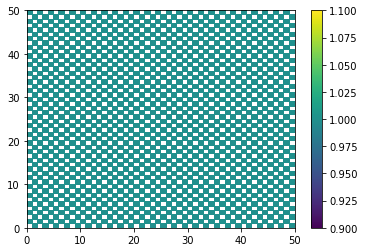

In [9]:
plt.pcolor(test);plt.colorbar()

In [155]:
test2 = np.zeros((50,50))*np.nan
test2[10:40,15:45] = 1
test2[20:30,5:10] = 1
#test2[30:35,5:10] = 1
#test2[27:29,20:22] = 1
#test2[27:29,20:22] = 1
#test2[22:24,17:19] = 1
#test2[5:7,40:43] = 1; test2[47:49,5:8] = 1

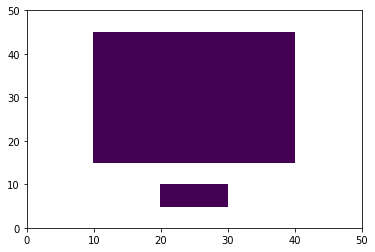

In [157]:
plt.pcolor(test2.T)

In [158]:
corgv.iorg(test2)

0.2804308824378384

In [135]:
test2 = np.zeros((50,50))*np.nan
test2[15:20,13:18] = 1
test2[20:30,23:33] = 1
test2[30:35,13:18] = 1
test2[27:29,18:20] = 1
test2[27:29,18:20] = 1

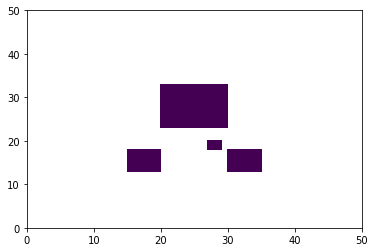

In [136]:
plt.pcolor(test2.T)

In [ ]:
#test2 = np.random.randint(0,2,size=(20,20))

cloudmask=test

cloudproperties = get_cloudproperties(cloudmask,connectivity=1)

centroids = [prop.centroid for prop in cloudproperties]
indices = np.arange(len(centroids))
neighbor_distance = np.zeros(len(centroids))
centroids_array = np.asarray(centroids)

for n, point in enumerate(centroids):
    # use all center of mass coordinates, but the one from the point
    mytree = sc.spatial.cKDTree(centroids_array[indices != n])
    dist, indexes = mytree.query(point)
    neighbor_distance[n] = dist

#     nn_sorted = np.sort(neighbor_distance)

#     nncdf = np.array(range(len(neighbor_distance))) / len(neighbor_distance)

#     # theoretical nearest neighbor cumulative frequency
#     # distribution (nncdf) of a random point process (Poisson)
#     lamb = (len(neighbor_distance) /
#             (cloudmask.shape[0] * cloudmask.shape[1]))
#     nncdf_poisson = 1 - np.exp(-lamb * np.pi * nn_sorted**2)

# revised
nn_sorted = np.sort(neighbor_distance)
Dmax = np.sqrt(cloudmask.shape[0]**2 + cloudmask.shape[1]**2) # maximum distance
nn_normalized_dist = nn_sorted
dist_bins = np.linspace(0,Dmax,10000)
nncdf = np.zeros(len(dist_bins)-1)
for n in range(len(dist_bins)-1):
    idx = np.where(np.logical_and(nn_normalized_dist>=dist_bins[n],nn_normalized_dist<dist_bins[n+1]))[0]
    nncdf[n] = len(idx)
nncdf = np.cumsum(nncdf)/len(neighbor_distance)    

# theoretical nearest neighbor cumulative frequency
# distribution (nncdf) of a random point process (Poisson)
lamb = (len(neighbor_distance) /
        (cloudmask.shape[0] * cloudmask.shape[1]))
nncdf_poisson = 1 - np.exp(-lamb * np.pi * dist_bins[:-1]**2)

sc.integrate.trapz(y=nncdf, x=nncdf_poisson)

In [60]:
os.chdir('/data/willytsai/gridsat_BT/remap_0.1deg/2014_2018/')
files = glob('*.nc')
files[0]

'GRIDSAT-B1.2014.01.01.00._0.1deg.nc'

In [142]:
data = xr.open_dataset(files[1])
tbb = data.sel(lat=slice(0,5),lon=slice(60,65)).irwin_cdr
tbb_mask = np.copy(tbb)
tbb_mask[tbb_mask>240] = np.nan

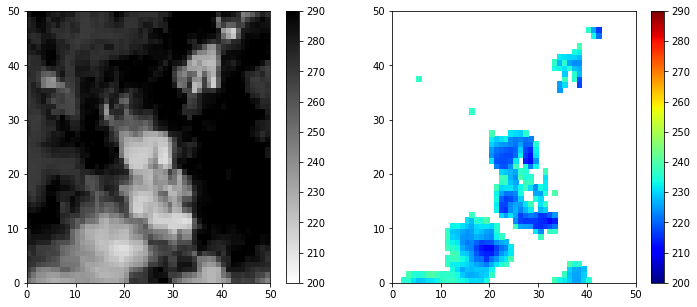

In [143]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
cf1 = ax[0].pcolor(tbb,cmap='binary',vmin=200,vmax=290);plt.colorbar(cf1,ax=ax[0])
cf2 = ax[1].pcolor(tbb_mask,cmap='jet',vmin=200,vmax=290);plt.colorbar(cf2,ax=ax[1])

In [144]:
corgv.iorg(tbb_mask)

0.6566507766386508

In [145]:
corg.iorg(tbb_mask)

0.6522139471430008